# 训练一个图像分类器

依次按照下列顺序进行：
1. 使用``torchvision``加载和归一化CIFAR10训练集和测试集
2. 定义一个卷积神经网络
3. 定义损失函数
4. 在训练集上训练网络
5. 保存训练好的模型
6. 在测试集上测试网络

## 1. 读取和归一化 CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision的输出是[0,1]的PILImage图像，我们把它转换为归一化。

In [3]:
batchsz = 128 #批量大小

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# 加载训练数据集
trainset = torchvision.datasets.CIFAR10(root='./datasets/cifar-10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsz,
                                          shuffle=True, num_workers=2)
# 加载测试数据集
testset = torchvision.datasets.CIFAR10(root='./datasets/cifar-10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsz,
                                         shuffle=True, num_workers=2)
# Cifar-10数据集类别
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


truck  ship  bird plane


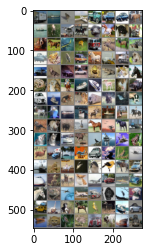

In [4]:
# 避免jupyter内核挂掉
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 导入python画图库
import matplotlib.pyplot as plt
import numpy as np

# 展示图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# 获取随机数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 展示图像
imshow(torchvision.utils.make_grid(images))
# 显示图像标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


2. 定义一个卷积神经网络LeNet5，并修改为输入3通道图像。

In [5]:
import  torch
from    torch import nn
from    torch.nn import functional as F

class Lenet5(nn.Module):
    """
    for cifar10 dataset.
    """
    
    def __init__(self):
        super(Lenet5, self).__init__()

        self.conv_unit = nn.Sequential(
            # x: [b, 3, 32, 32] => [b, 6, 28, 28]
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            # x: [b, 6, 28, 28] => [b, 6, 14, 14]
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            # x: [b, 6, 14, 14] = > [b, 16, 10, 10]
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            # x: [b, 16, 10, 10] = > [b, 16, 5, 5]
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        # flatten
        # fc unit
        self.fc_unit = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        """

        :param x: [b, 3, 32, 32]
        :return:
        """
        batchsz = x.size(0)
        # [b, 3, 32, 32] => [b, 16, 5, 5]
        x = self.conv_unit(x)
        # [b, 16, 5, 5] => [b, 16*5*5]
        x = x.view(batchsz, 16*5*5)
        # [b, 16*5*5] => [b, 10]
        logits = self.fc_unit(x)

        return logits
    
net = Lenet5()


3. 定义损失函数和优化器

我们使用交叉熵作为损失函数，使用带动量的随机梯度下降。



In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 在GPU上训练
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = net.to(device)
# 定义学习率、损失函数和优化器
learning_rate = 0.01
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# 变化学习率
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[30,80],gamma = 0.1)
print(net)

cuda:0
Lenet5(
  (conv_unit): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_unit): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)



4. 训练网络
--------------------------------
只需在数据迭代器上循环，将数据输入给网络，并优化。



In [8]:
epoch_num = 100

for epoch in range(epoch_num):  # 多批次循环
    # 学习率衰减
    scheduler.step()

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 正向传播
        outputs = net(inputs)
        # 计算损失值
        loss = criterion(outputs, labels)
        
        # 梯度置0
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 优化
        optimizer.step()

        # 打印状态信息
        running_loss += loss.item()
        if i % 3 == 2:    # 每3批次打印一次， 在 gpu 上训练请调大此参数
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2))
            running_loss = 0.0

print('Finished Training')

D:\anaconda3\envs\mmd26\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,     3] loss: 3.435
[1,     6] loss: 3.338
[1,     9] loss: 3.171
[1,    12] loss: 3.166
[1,    15] loss: 3.130
[1,    18] loss: 3.048
[1,    21] loss: 2.956
[1,    24] loss: 2.943
[1,    27] loss: 2.927
[1,    30] loss: 2.906
[1,    33] loss: 2.776
[1,    36] loss: 2.823
[1,    39] loss: 2.808
[1,    42] loss: 2.731
[1,    45] loss: 2.722
[1,    48] loss: 2.760
[1,    51] loss: 2.720
[1,    54] loss: 2.771
[1,    57] loss: 2.679
[1,    60] loss: 2.495
[1,    63] loss: 2.721
[1,    66] loss: 2.665
[1,    69] loss: 2.514
[1,    72] loss: 2.783
[1,    75] loss: 2.561
[1,    78] loss: 2.449
[1,    81] loss: 2.615
[1,    84] loss: 2.518
[1,    87] loss: 2.448
[1,    90] loss: 2.651
[1,    93] loss: 2.566
[1,    96] loss: 2.544
[1,    99] loss: 2.514
[1,   102] loss: 2.526
[1,   105] loss: 2.487
[1,   108] loss: 2.681
[1,   111] loss: 2.498
[1,   114] loss: 2.542
[1,   117] loss: 2.547
[1,   120] loss: 2.574
[1,   123] loss: 2.486
[1,   126] loss: 2.411
[1,   129] loss: 2.600
[1,   132] 

5. 保存训练好的模型

In [9]:
# torch.save(net, 'model100.pkl')
torch.save(net, 'model100_lr.pkl')


6. 在测试集上测试网络

通过预测神经网络输出的类别标签与实际情况标签进行对比来进行检测。

第一步，显示测试集中的图片

GroundTruth:  plane truck truck   dog


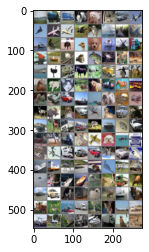

In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

第一步，加载一个训练好的模型

In [11]:
# 加载一个提前训练好的模型模型（100 个epoch）
net = torch.load('model100_lr.pkl')

让我们看看神经网络认为以上图片是什么。

In [13]:
device = torch.device("cpu")
net = net.to(device)
outputs = net(images)

输出是10个标签的概率。
一个类别的概率越大，神经网络越认为它是这个类别。所以让我们得到最高概率的标签。


In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship truck  ship   dog


网络在整个测试集上的结果

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


网络在每一类测试集上的结果

In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 78 %
Accuracy of  bird : 52 %
Accuracy of   cat : 37 %
Accuracy of  deer : 61 %
Accuracy of   dog : 36 %
Accuracy of  frog : 58 %
Accuracy of horse : 62 %
Accuracy of  ship : 63 %
Accuracy of truck : 70 %
